In [73]:
import os
import sys
import torch
import numpy as np
from scipy.stats import ks_2samp
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# from tqdm.rich import tqdm
from tqdm import tqdm
import h5py

import seaborn as sns
import matplotlib.pylab as plt
sys.path.append("..") 
from emd import emd_pot
from data import get_database_path, get_h5_files, read_h5_file
from utils import load_toml_config
np.random.seed(114514)

In [74]:
from data import sample_matrix, sample_pairs

# Sample processing

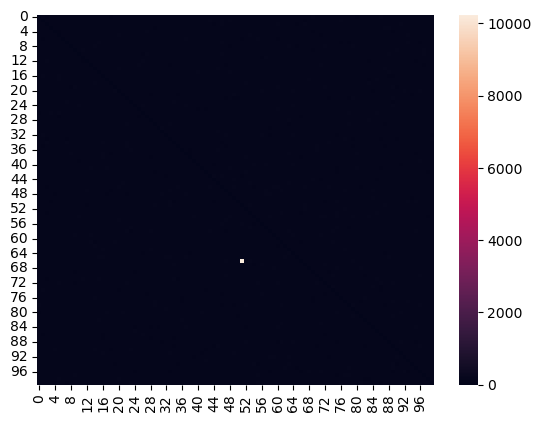

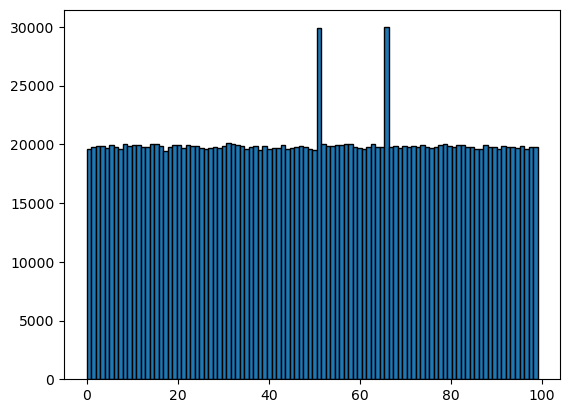

In [75]:
test_n_events = 100
test_n_pairs = 1000000
test_pairs = sample_pairs(test_n_events, test_n_pairs)
test_matrix = sample_matrix(test_n_events, test_pairs)
ax = sns.heatmap(test_matrix)
plt.show()
plt.hist(test_pairs.flatten(), bins=test_n_events, edgecolor='black')
plt.show()

# Sample Pairs and Calculate EMD

In [76]:
from data import sample_pairs_with_emd, store_emds_with_pairs
from utils import load_toml_config

In [77]:
files = load_toml_config("file")
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

print(files.keys())
bkg = read_h5_file(database_path, files["SM"])
# SM processes

neutral_boson = read_h5_file(database_path, files["neutral_boson"])
# A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

leptoquark = read_h5_file(database_path, files["leptoquark"])
# A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

neutral_Higgs = read_h5_file(database_path, files["neutral_Higgs"])
# A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

charged_Higgs = read_h5_file(database_path, files["charged_Higgs"])
# A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino


dict_keys(['SM', 'neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs'])


In [78]:
EMD_config = load_toml_config('EMD')

In [79]:
print(EMD_config)
particle_type_scale = EMD_config['particle_type_scale']
pair = EMD_config['n_pair']
norm = EMD_config['norm']
save_emd = EMD_config['save_emd']
particle_one_hot = EMD_config['particle_one_hot']

{'particle_type_scale': 0, 'particle_one_hot': True, 'n_pair': 2000000, 'norm': False, 'save_emd': True}


In [80]:
bkg_pairs, bkg_emds = sample_pairs_with_emd(bkg, n_pairs=pair, particle_type_scale=particle_type_scale, norm=norm, particle_one_hot=particle_one_hot)


neutral_boson_pairs, neutral_boson_emds = sample_pairs_with_emd(neutral_boson, particle_type_scale=particle_type_scale, norm=norm, particle_one_hot=particle_one_hot)


leptoquark_pairs, leptoquark_emds = sample_pairs_with_emd(leptoquark, particle_type_scale=particle_type_scale, norm=norm, particle_one_hot=particle_one_hot)


neutral_higgs_pairs, neutral_higgs_emds = sample_pairs_with_emd(neutral_Higgs, particle_type_scale=particle_type_scale, norm=norm, particle_one_hot=particle_one_hot)


charged_higgs_pairs, charged_higgs_emds = sample_pairs_with_emd(charged_Higgs, particle_type_scale=particle_type_scale, norm=norm, particle_one_hot=particle_one_hot)

if save_emd:
    store_emds_with_pairs(bkg_emds, bkg_pairs, "bkg_emds_type_scale{}.h5".format(particle_type_scale))
    store_emds_with_pairs(neutral_boson_emds, neutral_boson_pairs, "neutral_boson_emds_type_scale{}.h5".format(particle_type_scale))
    store_emds_with_pairs(leptoquark_emds, leptoquark_pairs, "leptoquark_emds_type_scale{}.h5".format(particle_type_scale))
    store_emds_with_pairs(neutral_higgs_emds, neutral_higgs_pairs, "neutral_higgs_emds_type_scale{}.h5".format(particle_type_scale))
    store_emds_with_pairs(charged_higgs_emds, charged_higgs_pairs, "charged_higgs_emds_type_scale{}.h5".format(particle_type_scale))

100%|██████████| 3801360/3801360 [03:22<00:00, 18760.91it/s]


In [81]:
sig_color = load_toml_config("sig_color")

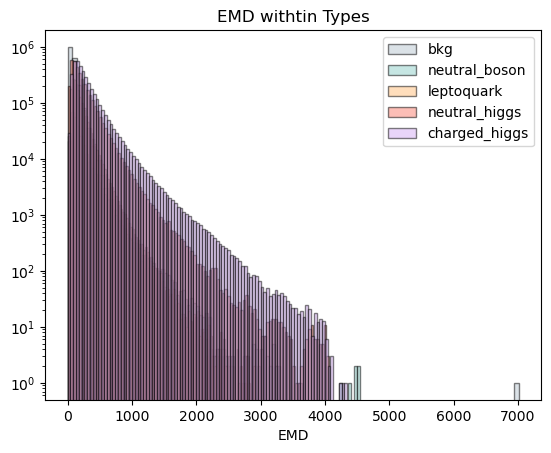

In [82]:
plt.hist(bkg_emds, bins=100, edgecolor='black', color=sig_color['SM'], alpha=0.5, label='bkg')
plt.hist(neutral_boson_emds, bins=100, edgecolor='black', color=sig_color['neutral_boson'], alpha=0.5, label='neutral_boson')
plt.hist(leptoquark_emds, bins=100, edgecolor='black', color=sig_color['leptoquark'], alpha=0.5, label='leptoquark')
plt.hist(neutral_higgs_emds, bins=100, edgecolor='black', color=sig_color['neutral_Higgs'], alpha=0.5, label='neutral_higgs')
plt.hist(charged_higgs_emds, bins=100, edgecolor='black', color=sig_color['charged_Higgs'], alpha=0.5, label='charged_higgs')
plt.yscale('log')
plt.legend()
plt.title("EMD withtin Types")
plt.xlabel("EMD")
plt.show()

In [83]:
def sample_pairs_from_diff_dataset(events1, events2, n_pairs, particle_type_scale=0, norm=False):
    index1 = np.random.randint(0, len(events1), n_pairs)
    index2 = np.random.randint(0, len(events2), n_pairs)
    pairs = np.stack([index1, index2], axis=1)
    emds = np.zeros(n_pairs)
    for i, (idx1, idx2) in enumerate(tqdm(pairs)):
        emds[i] = emd_pot(events1[idx1], events2[idx2], particle_type_scale=particle_type_scale, norm=norm)
    return pairs, emds

In [84]:
from data import sample_pairs_from_diff_dataset

In [85]:
bkg_neutral_boson_pairs, bkg_neutral_boson_emds = sample_pairs_from_diff_dataset(bkg, neutral_boson, pair, particle_type_scale=particle_type_scale, norm=norm)
bkg_leptoquark_pairs, bkg_leptoquark_emds = sample_pairs_from_diff_dataset(bkg, leptoquark, pair, particle_type_scale=particle_type_scale, norm=norm)
bkg_neutral_higgs_pairs, bkg_neutral_higgs_emds = sample_pairs_from_diff_dataset(bkg, neutral_Higgs, pair, particle_type_scale=particle_type_scale, norm=norm)
bkg_charged_higgs_pairs, bkg_charged_higgs_emds = sample_pairs_from_diff_dataset(bkg, charged_Higgs, pair, particle_type_scale=particle_type_scale, norm=norm)

  0%|          | 0/2000000 [00:00<?, ?it/s]

100%|██████████| 2000000/2000000 [01:47<00:00, 18631.12it/s]


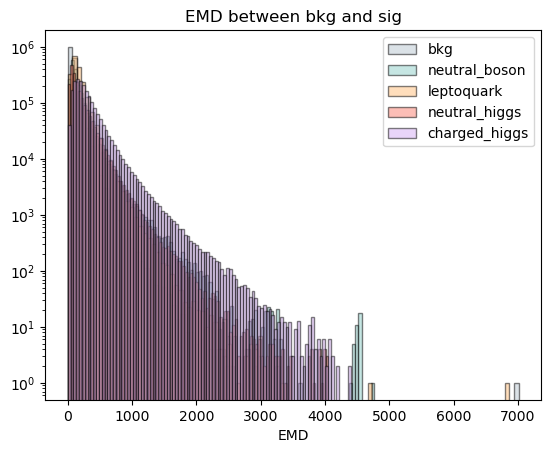

In [86]:
bins = np.linspace(0, 1000, 100)
# bins = 100

plt.hist(bkg_emds, bins=100, edgecolor='black', color=sig_color['SM'], alpha=0.5, label='bkg')
plt.hist(bkg_neutral_boson_emds, bins=100, edgecolor='black', color=sig_color['neutral_boson'], alpha=0.5, label='neutral_boson')
plt.hist(bkg_leptoquark_emds, bins=100, edgecolor='black', color=sig_color['leptoquark'], alpha=0.5, label='leptoquark')
plt.hist(bkg_neutral_higgs_emds, bins=100, edgecolor='black', color=sig_color['neutral_Higgs'], alpha=0.5, label='neutral_higgs')
plt.hist(bkg_charged_higgs_emds, bins=100, edgecolor='black', color=sig_color['charged_Higgs'], alpha=0.5, label='charged_higgs')
plt.yscale('log')
plt.legend()
plt.title("EMD between bkg and sig")
plt.xlabel("EMD")
plt.show()

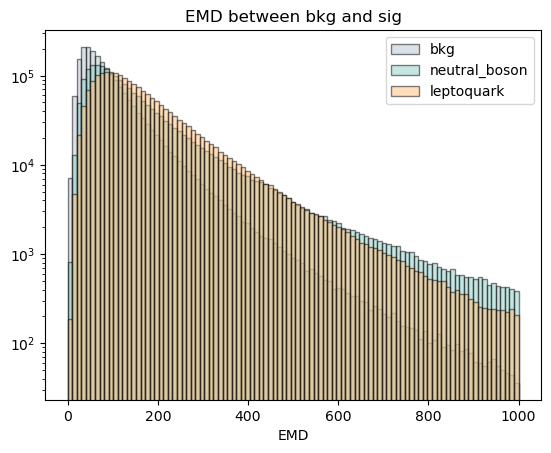

In [87]:
bins = np.linspace(0, 1000, 100)
# bins = 100
plt.hist(bkg_emds, bins=bins, edgecolor='black', color=sig_color['SM'], alpha=0.5, label='bkg')
plt.hist(bkg_neutral_boson_emds, bins=bins, edgecolor='black', color=sig_color['neutral_boson'], alpha=0.5, label='neutral_boson')
plt.hist(bkg_leptoquark_emds, bins=bins, edgecolor='black', color=sig_color['leptoquark'], alpha=0.5, label='leptoquark')
plt.yscale('log')
plt.legend()
plt.title("EMD between bkg and sig")
plt.xlabel("EMD")
plt.show()

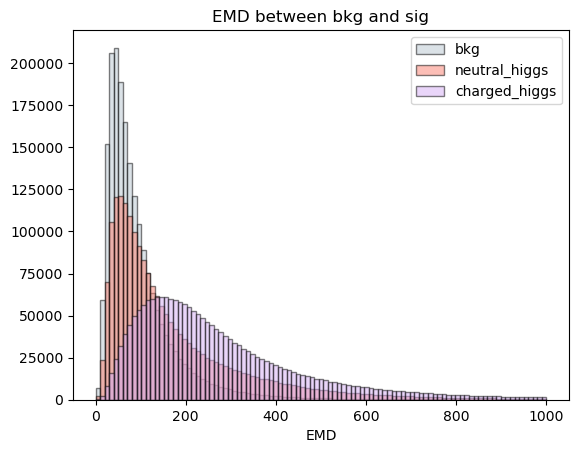

In [88]:
bins = np.linspace(0, 1000, 100)
# bins = 100
plt.hist(bkg_emds, bins=bins, edgecolor='black', color=sig_color['SM'], alpha=0.5, label='bkg')
plt.hist(bkg_neutral_higgs_emds, bins=bins, edgecolor='black', color=sig_color['neutral_Higgs'], alpha=0.5, label='neutral_higgs')
plt.hist(bkg_charged_higgs_emds, bins=bins, edgecolor='black', color=sig_color['charged_Higgs'], alpha=0.5, label='charged_higgs')
# plt.yscale('log')
plt.legend()
plt.title("EMD between bkg and sig")
plt.xlabel("EMD")
plt.show()

# KS test
Measure the dissimilarity

In [89]:
print("Particle type scale", particle_type_scale)
print("One-hot encoding" if particle_one_hot else "Type in extra dimension")
ks_bkg_neutral_boson = ks_2samp(bkg_emds, bkg_neutral_boson_emds)[0]
ks_bkg_leptoquark = ks_2samp(bkg_emds, bkg_leptoquark_emds)[0]
ks_bkg_neutral_higgs = ks_2samp(bkg_emds, bkg_neutral_higgs_emds)[0]
ks_bkg_charged_higgs = ks_2samp(bkg_emds, bkg_charged_higgs_emds)[0]
print("Distance between bkg and neutral boson", ks_bkg_neutral_boson)
print("Distance between bkg and leptoquark", ks_bkg_leptoquark)
print("Distance between bkg and neutral higgs", ks_bkg_neutral_higgs)
print("Distance between bkg and charged higgs", ks_bkg_charged_higgs)
total_ks = ks_bkg_neutral_boson + ks_bkg_leptoquark + ks_bkg_neutral_higgs + ks_bkg_charged_higgs
print("Total distance", total_ks)

Particle type scale 0
One-hot encoding
Distance between bkg and neutral boson 0.23592400000000002
Distance between bkg and leptoquark 0.35217
Distance between bkg and neutral higgs 0.25067999999999996
Distance between bkg and charged higgs 0.568964
Total distance 1.407738


In [33]:
ks_2samp(bkg_emds, bkg_emds)

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.5993613284056467, statistic_sign=1)